# Inverse design quickstart - level 1

This notebook will get users up and running with a very simple [inverse design optimization](https://www.flexcompute.com/tidy3d/inverse-design/) with `tidy3d`. Inverse design uses the **adjoint method** to compute gradients of a figure of merit with respect to design parameters using only 2 simulations, no matter how many design parameters are present. This gradient is then used to do high-dimensional gradient-based optimization of the system.

The setup we'll demonstrate here involves a point dipole source and a point field monitor on either side of a dielectric box. We use gradient-based optimization to maximize the intensity enhancement at the measurement spot with respect to the box size in all 3 dimensions.

<img src="img/Adjoint_Quickstart.png" width="300" alt="Schematic of the design problem.">

For more advanced inverse design examples and tutorial notebooks, check out

* [Tidy3D Autograd Tutorial](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd1Intro/).

* [Topology Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd3InverseDesign/).

* [Shape Optimization](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd5BoundaryGradients/).

* [Grating Coupler Inverse Design](https://www.flexcompute.com/tidy3d/examples/notebooks/Autograd6GratingCoupler/).

To see all Tidy3D [examples](https://www.flexcompute.com/tidy3d/learning-center/example-library/) and [tutorials](https://www.flexcompute.com/tidy3d/learning-center/tidy3d-python/), as well as other learning materials, please visit our [Learning Center](https://www.flexcompute.com/tidy3d/learning-center/).


In [1]:
import autograd as ag
import autograd.numpy as anp
import tidy3d as td
from tidy3d.web import run

First, we define a function to create a Tidy3D [Simulation](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Simulation.html) given the size of the dielectric [Box](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.Box.html). We create a [PointDipole](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.PointDipole.html) source as excitation and a [FieldMonitor](https://docs.flexcompute.com/projects/tidy3d/en/latest/api/_autosummary/tidy3d.FieldMonitor.html) to measure the field distribution. Later we will extract the field intensity at a point and use that as the objective function for the optimization.

In [2]:
def make_sim(size_box: float) -> td.Simulation:
    """Create a tidy3d simulation given a box size."""

    # create a dipole source on the left side of the simulation
    source = td.PointDipole(
        center=(-6, 0, 0),  # position of the dipole
        source_time=td.GaussianPulse(freq0=td.C_0 / 1.55, fwidth=0.1 * td.C_0 / 1.55),
        polarization="Ez",
    )

    # create a monitor on the right side of the simulation to measure field intensity
    monitor = td.FieldMonitor(
        size=(td.inf, td.inf, 0.0),
        freqs=[td.C_0 / 1.55],
        name="field",
    )

    # create a box with the given size
    box = td.Structure(
        geometry=td.Box(center=(0, 0, 0), size=(size_box, size_box, size_box)),
        medium=td.Medium(permittivity=2),
    )

    # create the simulation
    sim = td.Simulation(
        size=(16, 16, 16),
        grid_spec=td.GridSpec.auto(min_steps_per_wvl=20),
        structures=[box],
        sources=[source],
        monitors=[monitor],
        run_time=5e-13,
    )

    return sim

## Define Objective Function

The crucial step in inverse design is to define the objective function. Now we can construct our objective function, which is simply the intensity at the measurement point $(x=6, y=0)$ as a function of the box size.

In [ ]:
def objective_fn(size_box: float) -> float:
    """Calculate the intensity at the monitor position given a box size."""

    # create and run the simulation through the tidy3d web API
    sim_data = run(simulation=make_sim(size_box), task_name="adjoint_quickstart", verbose=False)

    # evaluate the intensity at the measurement position
    intensity = anp.sum(
        sim_data.get_intensity("field").sel(x=6, y=0, method="nearest").values
    )  # extract intensity at x=6 and y=0

    return intensity

## Optimization Loop

Next, we use `autograd` to construct a function that returns the gradient of our objective function and use this to run our gradient-based optimization in a for loop.

In [4]:
# use autograd to get a function that returns the objective function and its gradient
val_and_grad_fn = ag.value_and_grad(objective_fn)

size_box = 2.5  # initial box size

# we will run the optimization for 7 iterations
for i in range(7):
    # compute gradient and current objective function value
    value, gradient = val_and_grad_fn(size_box)

    # update the parameter with the gradient and a learning rate of 2e-4
    size_box = size_box + gradient * 2e-4

    print(f"Iteration = {i + 1}\n\tsize_box = {size_box:.2f}\n\tintensity = {value:.0f}")

Iteration = 1
	size_box = 2.68
	intensity = 861
Iteration = 2
	size_box = 2.89
	intensity = 1068
Iteration = 3
	size_box = 3.07
	intensity = 1258
Iteration = 4
	size_box = 3.25
	intensity = 1402
Iteration = 5
	size_box = 3.72
	intensity = 1703
Iteration = 6
	size_box = 3.90
	intensity = 2233
Iteration = 7
	size_box = 4.08
	intensity = 2432


## Analysis

After the optimization, the final field distribution is plotted. We denote the source position with a green dot and the measurement position with an orange dot. The orange dot is near a field hotspot as a result of the optimization.

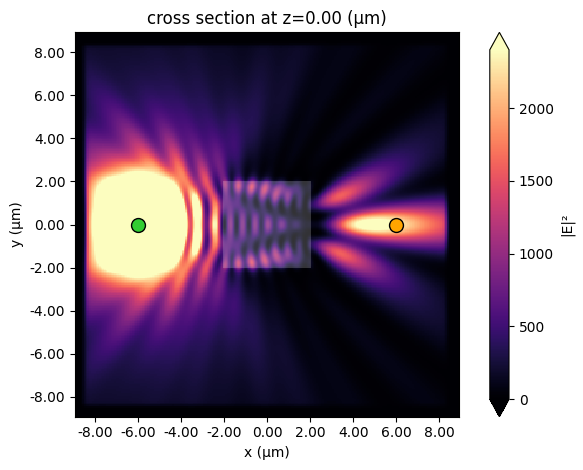

In [5]:
data_final = run(simulation=make_sim(size_box), task_name="final_result", verbose=False)

# plot intensity distribution
ax = data_final.plot_field(field_monitor_name="field", field_name="E", val="abs^2", vmax=2400)

ax.plot(-6, 0, marker="o", mfc="limegreen", mec="black", ms=10)
ax.plot(6, 0, marker="o", mfc="orange", mec="black", ms=10);